In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 31 14:51:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   35C    P0    31W / 165W |      0MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.6271578009909717
GPU (s):
0.03075413299666252
GPU speedup over CPU: 20x


In [3]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
def train_model(img_dir, preprocess):

  data_dir = pathlib.Path(img_dir)

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if preprocess == True:
    x = tf.keras.applications.densenet.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
74850304/74836368 [==============================] - 60s 1us/step
Using preprocessing
Epoch 1/100
360/360 [==============================] - 39s 74ms/step - loss: 0.8934 - accuracy: 0.6595 - val_loss: 0.6668 - val_accuracy: 0.7228
Epoch 2/100
360/360 [==============================] - 22s 62ms/step - loss: 0.6799 - accuracy: 0.7144 - val_loss: 0.6257 - val_accuracy: 0.7440
Epoch 3/100
360/360 [==============================] - 21s 59ms/step - loss: 0.6418 - accuracy: 0.7316 - val_loss: 0.6530 - val_accuracy: 0.7310
Epoch 4/100
360/360 [==============================] - 21s 58ms/step - loss: 0.6183 - accuracy: 0.7423 - val_loss: 0.6135 - val_accuracy: 0.7426
Epoch 5/100
360/360 [==============================] - 21s 57ms/step - loss: 0.6197 - accuracy: 0.7432 - val_loss: 0.6018 - val_accuracy: 0.7487
Epoch 6/100
360/360 [===================

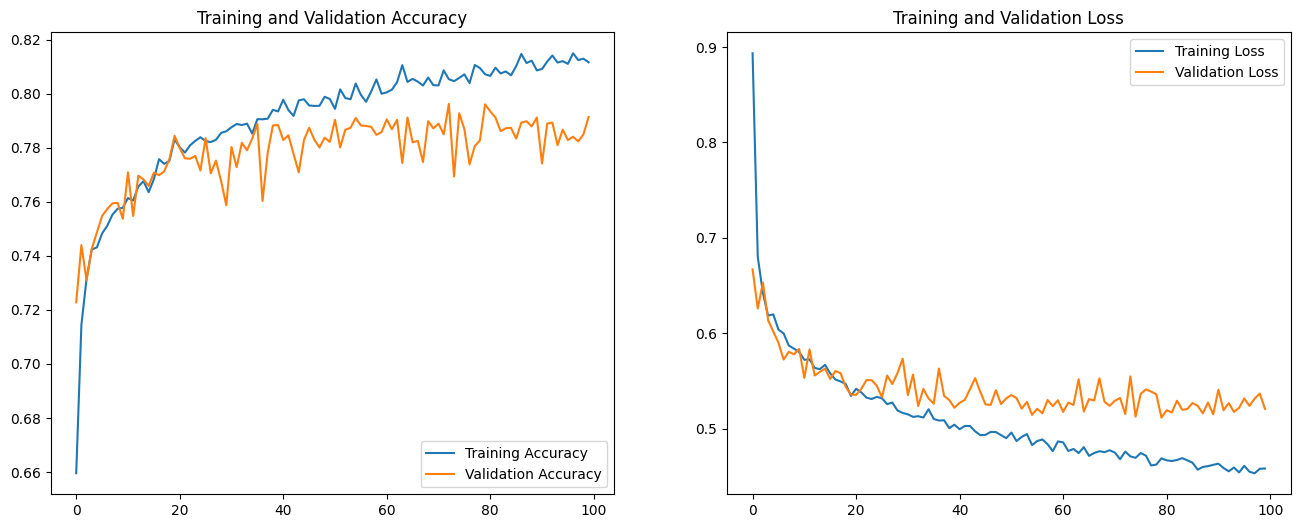

In [5]:
res_hls_pre = train_model('content/img_HLS', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 34s 65ms/step - loss: 1.7723 - accuracy: 0.5041 - val_loss: 1.1329 - val_accuracy: 0.4958
Epoch 2/100
360/360 [==============================] - 22s 60ms/step - loss: 0.9971 - accuracy: 0.5602 - val_loss: 1.0816 - val_accuracy: 0.5375
Epoch 3/100
360/360 [==============================] - 20s 56ms/step - loss: 0.9440 - accuracy: 0.5876 - val_loss: 1.1662 - val_accuracy: 0.4852
Epoch 4/100
360/360 [==============================] - 21s 57ms/step - loss: 0.9154 - accuracy: 0.5983 - val_loss: 1.2311 - val_accuracy: 0.4832
Epoch 5/100
360/360 [==============================] - 22s 61ms/step - loss: 0.8937 - accuracy: 0.6113 - val_loss: 1.2050 - val_accuracy: 0.5290
Epoch 6/100
360/360 [==============================] - 21s 57ms/step - loss: 0.8858 - accuracy: 0.6126 - val_loss: 1.1417 - va

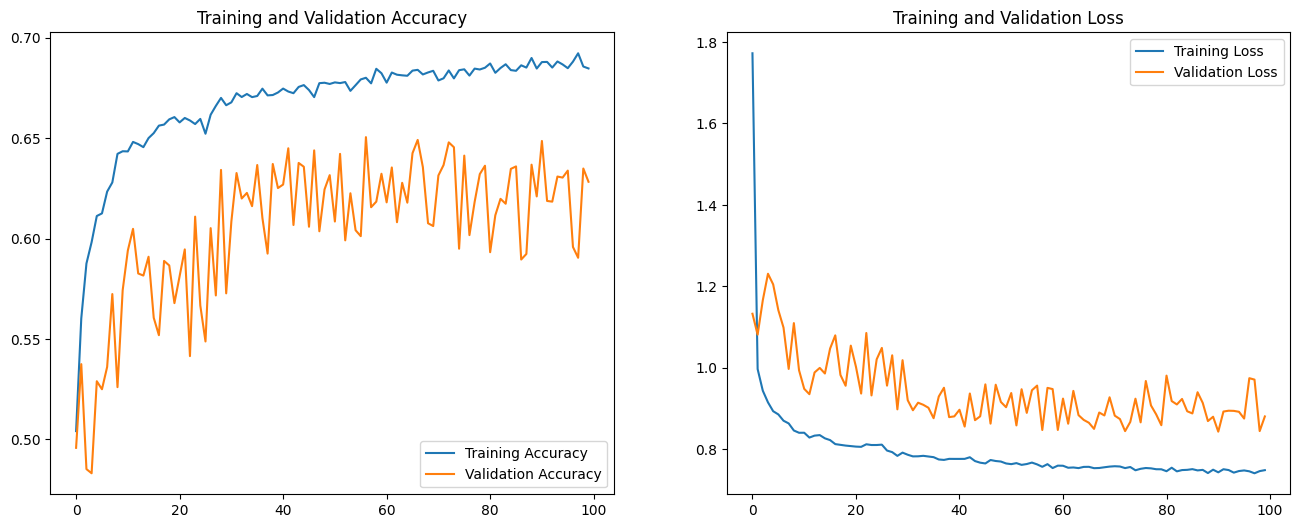

In [6]:
res_hls_nonpre = train_model('content/img_HLS', preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 35s 67ms/step - loss: 0.6464 - accuracy: 0.7283 - val_loss: 0.4756 - val_accuracy: 0.8050
Epoch 2/100
360/360 [==============================] - 21s 59ms/step - loss: 0.5237 - accuracy: 0.7810 - val_loss: 0.4445 - val_accuracy: 0.8197
Epoch 3/100
360/360 [==============================] - 21s 58ms/step - loss: 0.4918 - accuracy: 0.7941 - val_loss: 0.4486 - val_accuracy: 0.8180
Epoch 4/100
360/360 [==============================] - 20s 56ms/step - loss: 0.4834 - accuracy: 0.8009 - val_loss: 0.4298 - val_accuracy: 0.8284
Epoch 5/100
360/360 [==============================] - 20s 57ms/step - loss: 0.4618 - accuracy: 0.8062 - val_loss: 0.4253 - val_accuracy: 0.8242
Epoch 6/100
360/360 [==============================] - 21s 58ms/step - loss: 0.4554 - accuracy: 0.8137 - v

360/360 [==============================] - 20s 56ms/step - loss: 0.3473 - accuracy: 0.8605 - val_loss: 0.3609 - val_accuracy: 0.8595
Epoch 57/100
360/360 [==============================] - 20s 56ms/step - loss: 0.3470 - accuracy: 0.8602 - val_loss: 0.3458 - val_accuracy: 0.8668
Epoch 58/100
360/360 [==============================] - 21s 57ms/step - loss: 0.3445 - accuracy: 0.8623 - val_loss: 0.3665 - val_accuracy: 0.8552
Epoch 59/100
360/360 [==============================] - 20s 57ms/step - loss: 0.3412 - accuracy: 0.8654 - val_loss: 0.3695 - val_accuracy: 0.8546
Epoch 60/100
360/360 [==============================] - 21s 59ms/step - loss: 0.3448 - accuracy: 0.8623 - val_loss: 0.3419 - val_accuracy: 0.8701
Epoch 61/100
360/360 [==============================] - 20s 56ms/step - loss: 0.3441 - accuracy: 0.8646 - val_loss: 0.3558 - val_accuracy: 0.8647
Epoch 62/100
360/360 [==============================] - 21s 57ms/step - loss: 0.3473 - accuracy: 0.8600 - val_loss: 0.3420 - val_accuracy

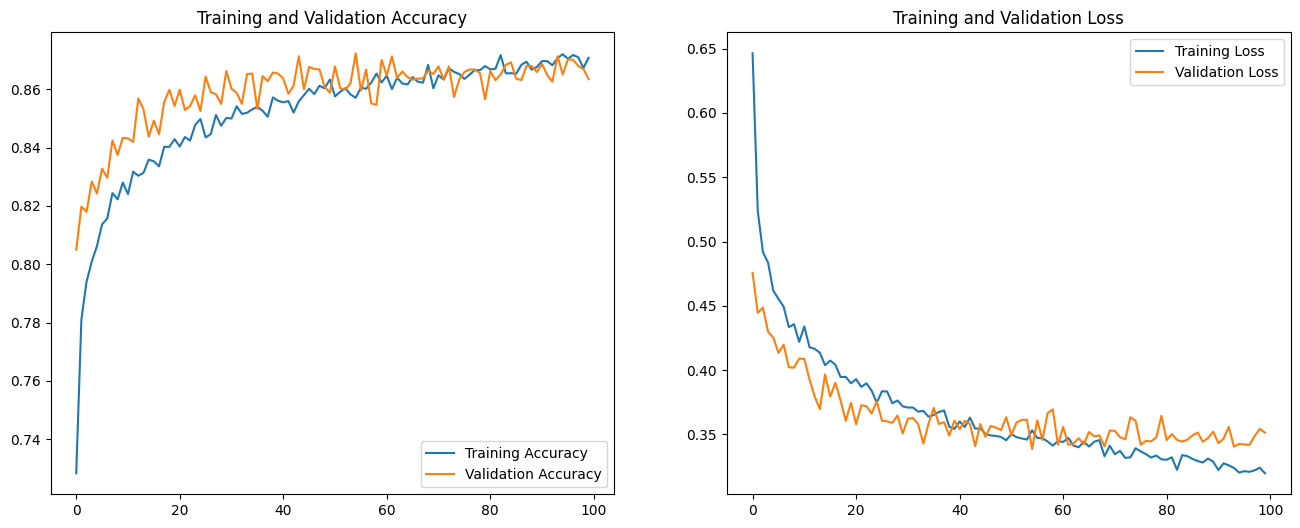

In [7]:
res_luv_pre = train_model('content/img_Luv', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 33s 64ms/step - loss: 1.5900 - accuracy: 0.5087 - val_loss: 0.8568 - val_accuracy: 0.6174
Epoch 2/100
360/360 [==============================] - 22s 61ms/step - loss: 0.9025 - accuracy: 0.6096 - val_loss: 0.7933 - val_accuracy: 0.6579
Epoch 3/100
360/360 [==============================] - 20s 56ms/step - loss: 0.8383 - accuracy: 0.6372 - val_loss: 0.7294 - val_accuracy: 0.6827
Epoch 4/100
360/360 [==============================] - 20s 55ms/step - loss: 0.8074 - accuracy: 0.6537 - val_loss: 0.7076 - val_accuracy: 0.6999
Epoch 5/100
360/360 [==============================] - 20s 55ms/step - loss: 0.7810 - accuracy: 0.6657 - val_loss: 0.6949 - val_accuracy: 0.7088
Epoch 6/100
360/360 [==============================] - 20s 57ms/step - loss: 0.7523 - accuracy: 0.6850 - val_loss: 0.7223 - va

360/360 [==============================] - 20s 56ms/step - loss: 0.5708 - accuracy: 0.7707 - val_loss: 0.5141 - val_accuracy: 0.8112
Epoch 57/100
360/360 [==============================] - 20s 55ms/step - loss: 0.5628 - accuracy: 0.7794 - val_loss: 0.5524 - val_accuracy: 0.7961
Epoch 58/100
360/360 [==============================] - 20s 56ms/step - loss: 0.5566 - accuracy: 0.7762 - val_loss: 0.5505 - val_accuracy: 0.7878
Epoch 59/100
360/360 [==============================] - 20s 56ms/step - loss: 0.5663 - accuracy: 0.7757 - val_loss: 0.5443 - val_accuracy: 0.8015
Epoch 60/100
360/360 [==============================] - 20s 55ms/step - loss: 0.5596 - accuracy: 0.7777 - val_loss: 0.5439 - val_accuracy: 0.7966
Epoch 61/100
360/360 [==============================] - 20s 55ms/step - loss: 0.5643 - accuracy: 0.7767 - val_loss: 0.5362 - val_accuracy: 0.7961
Epoch 62/100
360/360 [==============================] - 20s 56ms/step - loss: 0.5627 - accuracy: 0.7755 - val_loss: 0.5080 - val_accuracy

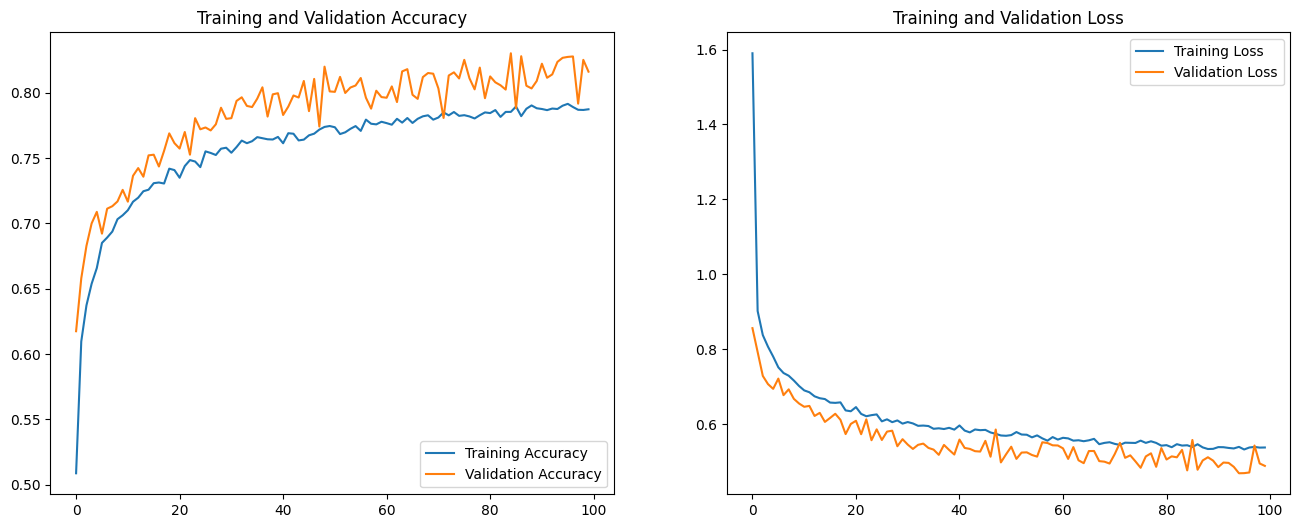

In [9]:
res_luv_nonpre = train_model('content/img_Luv', preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 34s 64ms/step - loss: 0.7079 - accuracy: 0.7089 - val_loss: 0.5165 - val_accuracy: 0.7850
Epoch 2/100
360/360 [==============================] - 20s 57ms/step - loss: 0.5544 - accuracy: 0.7658 - val_loss: 0.4856 - val_accuracy: 0.7928
Epoch 3/100
360/360 [==============================] - 21s 57ms/step - loss: 0.5199 - accuracy: 0.7778 - val_loss: 0.4998 - val_accuracy: 0.7937
Epoch 4/100
360/360 [==============================] - 21s 59ms/step - loss: 0.5041 - accuracy: 0.7888 - val_loss: 0.5232 - val_accuracy: 0.7697
Epoch 5/100
360/360 [==============================] - 21s 58ms/step - loss: 0.5058 - accuracy: 0.7842 - val_loss: 0.4655 - val_accuracy: 0.8051
Epoch 6/100
360/360 [==============================] - 20s 56ms/step - loss: 0.4893 - accuracy: 0.7945 - v

360/360 [==============================] - 20s 57ms/step - loss: 0.3830 - accuracy: 0.8443 - val_loss: 0.3741 - val_accuracy: 0.8479
Epoch 57/100
360/360 [==============================] - 20s 57ms/step - loss: 0.3765 - accuracy: 0.8474 - val_loss: 0.3911 - val_accuracy: 0.8378
Epoch 58/100
360/360 [==============================] - 20s 57ms/step - loss: 0.3848 - accuracy: 0.8422 - val_loss: 0.3955 - val_accuracy: 0.8376
Epoch 59/100
360/360 [==============================] - 20s 56ms/step - loss: 0.3815 - accuracy: 0.8449 - val_loss: 0.3798 - val_accuracy: 0.8463
Epoch 60/100
360/360 [==============================] - 20s 55ms/step - loss: 0.3782 - accuracy: 0.8458 - val_loss: 0.3832 - val_accuracy: 0.8433
Epoch 61/100
360/360 [==============================] - 20s 57ms/step - loss: 0.3772 - accuracy: 0.8465 - val_loss: 0.3773 - val_accuracy: 0.8479
Epoch 62/100
360/360 [==============================] - 21s 58ms/step - loss: 0.3838 - accuracy: 0.8425 - val_loss: 0.3882 - val_accuracy

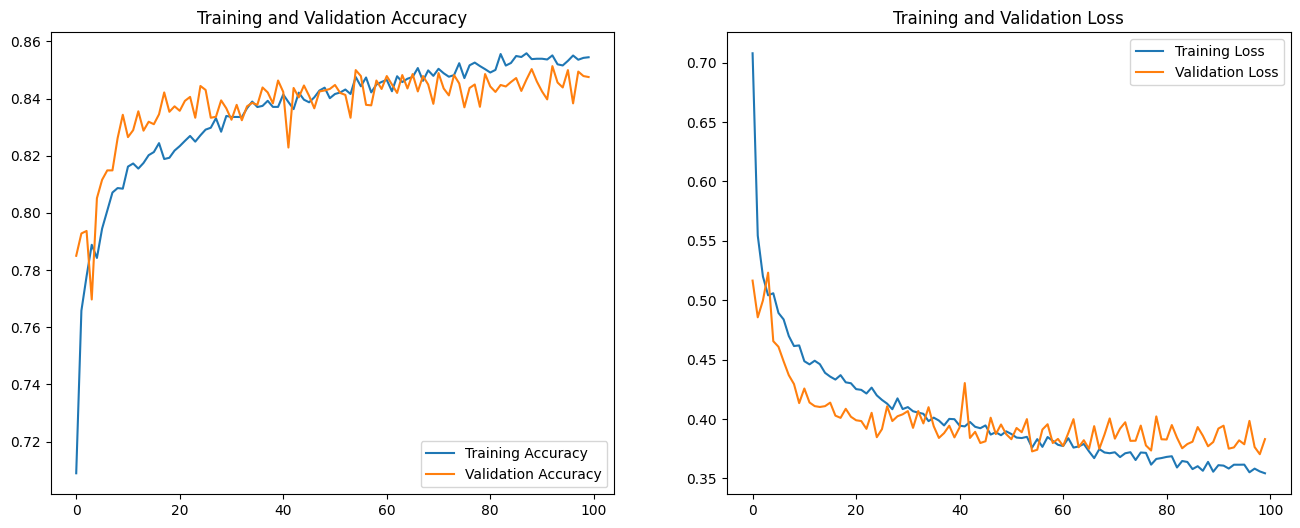

In [11]:
res_ycrcb_pre = train_model('content/img_YCrCb', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 34s 64ms/step - loss: 2.1170 - accuracy: 0.4675 - val_loss: 0.8958 - val_accuracy: 0.6202
Epoch 2/100
360/360 [==============================] - 20s 57ms/step - loss: 1.0156 - accuracy: 0.5703 - val_loss: 0.8401 - val_accuracy: 0.6327
Epoch 3/100
360/360 [==============================] - 20s 56ms/step - loss: 0.9348 - accuracy: 0.6052 - val_loss: 0.8071 - val_accuracy: 0.6634
Epoch 4/100
360/360 [==============================] - 20s 57ms/step - loss: 0.8886 - accuracy: 0.6272 - val_loss: 0.7966 - val_accuracy: 0.6657
Epoch 5/100
360/360 [==============================] - 20s 57ms/step - loss: 0.8564 - accuracy: 0.6329 - val_loss: 0.7757 - val_accuracy: 0.6690
Epoch 6/100
360/360 [==============================] - 20s 56ms/step - loss: 0.8332 - accuracy: 0.6479 - val_loss: 0.7409 - va

360/360 [==============================] - 20s 56ms/step - loss: 0.6510 - accuracy: 0.7415 - val_loss: 0.5633 - val_accuracy: 0.7831
Epoch 57/100
360/360 [==============================] - 20s 56ms/step - loss: 0.6501 - accuracy: 0.7381 - val_loss: 0.6066 - val_accuracy: 0.7615
Epoch 58/100
360/360 [==============================] - 20s 56ms/step - loss: 0.6459 - accuracy: 0.7401 - val_loss: 0.5846 - val_accuracy: 0.7742
Epoch 59/100
360/360 [==============================] - 20s 56ms/step - loss: 0.6409 - accuracy: 0.7425 - val_loss: 0.5572 - val_accuracy: 0.7815
Epoch 60/100
360/360 [==============================] - 20s 56ms/step - loss: 0.6420 - accuracy: 0.7425 - val_loss: 0.5646 - val_accuracy: 0.7866
Epoch 61/100
360/360 [==============================] - 20s 56ms/step - loss: 0.6381 - accuracy: 0.7440 - val_loss: 0.5824 - val_accuracy: 0.7721
Epoch 62/100
360/360 [==============================] - 20s 56ms/step - loss: 0.6413 - accuracy: 0.7412 - val_loss: 0.5843 - val_accuracy

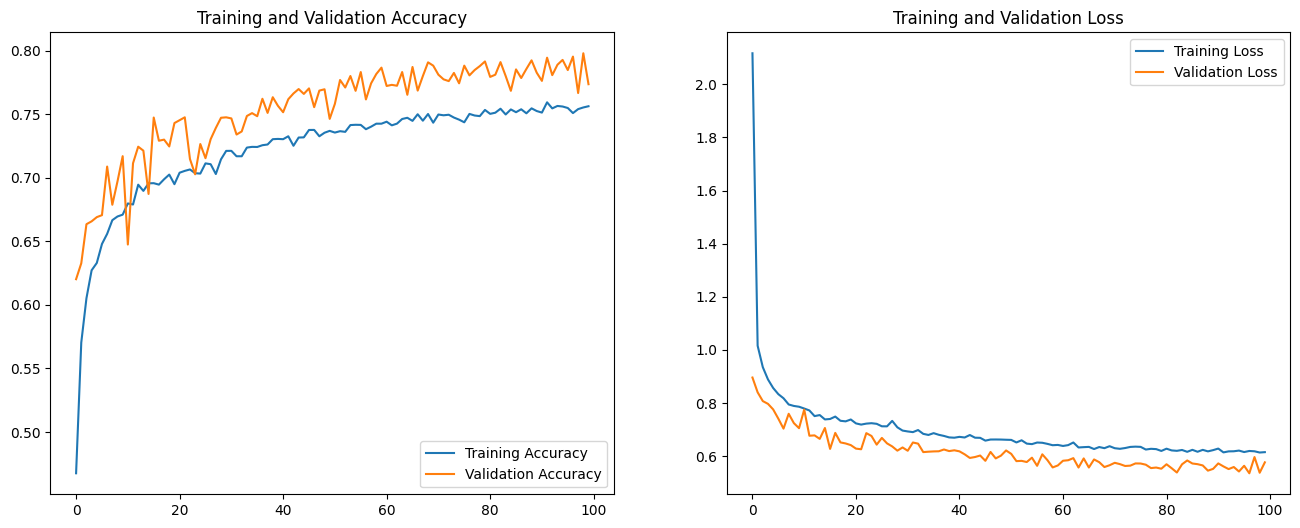

In [12]:
res_ycrcb_nonpre = train_model('content/img_YCrCb', preprocess=False)

In [13]:
pd.DataFrame(res_hls_pre).to_csv("densenet201_nontrainable/res_hls_pre.csv", index=False)
pd.DataFrame(res_hls_nonpre).to_csv("densenet201_nontrainable/res_hls_nonpre.csv", index=False)
pd.DataFrame(res_luv_pre).to_csv("densenet201_nontrainable/res_luv_pre.csv", index=False)
pd.DataFrame(res_luv_nonpre).to_csv("densenet201_nontrainable/res_luv_nonpre.csv", index=False)
pd.DataFrame(res_ycrcb_pre).to_csv("densenet201_nontrainable/res_ycrcb_pre.csv", index=False)
pd.DataFrame(res_ycrcb_nonpre).to_csv("densenet201_nontrainable/res_ycrcb_nonpre.csv", index=False)